# Test Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_hub as hub
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score

from imblearn.over_sampling import RandomOverSampler

import random

import joblib

import json

%matplotlib inline

Using TensorFlow backend.


In [2]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))
    print('F1 score:', round(f1_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens', vmin=0, vmax=1)
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [3]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsor_my_party,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,4.0,1,1,0,1,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,4.0,1,1,0,1,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,4.0,1,1,0,1,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,4.0,1,1,0,1,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,4.0,1,1,0,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102692 entries, 5 to 306260
Data columns (total 78 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       102692 non-null  int64  
 1   chamber                        102692 non-null  object 
 2   rollnumber                     102692 non-null  int64  
 3   icpsr                          102692 non-null  int64  
 4   cast_code                      102692 non-null  int64  
 5   state_abbrev                   102692 non-null  object 
 6   bioname                        102692 non-null  object 
 7   bioguide_id                    102692 non-null  object 
 8   born                           102692 non-null  int64  
 9   nominate_dim1                  102692 non-null  float64
 10  nominate_dim2                  102692 non-null  float64
 11  party                          102692 non-null  object 
 12  last_name                     

None

In [4]:
last_roll_per_bill = main_df.groupby(['congress', 'bill_number']).rollnumber.max().reset_index()
last_roll_per_bill.columns = ['congress', 'bill_number', 'last_rollcall']
main_df_last_roll = main_df.merge(last_roll_per_bill, how='left', on=['congress', 'bill_number'])

main_df = main_df_last_roll[main_df_last_roll['rollnumber'] == main_df_last_roll['last_rollcall']]

main_df = main_df.reset_index(drop=True)

display(main_df.head())
display(main_df.tail())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,4.0,1,1,0,1,0,1,1,0,1
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,4.0,1,1,0,1,1,1,0,0,1
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,4.0,1,1,0,1,0,1,1,0,1
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,4.0,1,1,0,1,1,1,0,0,1
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,4.0,1,1,0,1,1,1,0,0,1


,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
23221,116,Senate,508,49300,1,CA,"FEINSTEIN, Dianne",F000062,1933,-0.268,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23222,116,Senate,508,49308,1,WA,"MURRAY, Patty",M001111,1950,-0.350,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23223,116,Senate,508,49703,1,ME,"COLLINS, Susan Margaret",C001035,1952,0.112,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23224,116,Senate,508,49706,1,WY,"ENZI, Michael B.",E000285,1944,0.544,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23225,116,Senate,508,94659,1,AL,"SHELBY, Richard C.",S000320,1934,0.428,...,136161.0,40401,28224,0,28224,0,1,1,0,508


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23226 entries, 0 to 23225
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       23226 non-null  int64  
 1   chamber                        23226 non-null  object 
 2   rollnumber                     23226 non-null  int64  
 3   icpsr                          23226 non-null  int64  
 4   cast_code                      23226 non-null  int64  
 5   state_abbrev                   23226 non-null  object 
 6   bioname                        23226 non-null  object 
 7   bioguide_id                    23226 non-null  object 
 8   born                           23226 non-null  int64  
 9   nominate_dim1                  23226 non-null  float64
 10  nominate_dim2                  23226 non-null  float64
 11  party                          23226 non-null  object 
 12  last_name                      23226 non-null 

None

In [5]:
dep_col = 'cast_code'

logit_features = list(pd.read_pickle('final_features.pkl')['feature'].values)

text_cols = ['summary']

indep_cols = logit_features + text_cols

In [6]:
main_df['bill_slug'] = main_df['bill_number'] + '-' + main_df['congress'].apply(lambda x: str(x))

In [7]:
unique_bills = list(main_df['bill_slug'].unique())
percent_to_subset = .3
num_to_subset = round(len(unique_bills) * percent_to_subset)
subset_bills = random.sample(unique_bills, num_to_subset)

In [8]:
scalar = StandardScaler()

train_df = main_df[~main_df['bill_slug'].isin(subset_bills)]
test_df = main_df[main_df['bill_slug'].isin(subset_bills)]

non_text_cols = [x for x in indep_cols if x not in text_cols]

y_train = train_df[dep_col]
X_train = train_df[indep_cols]

y_test = test_df[dep_col]
X_test = test_df[indep_cols]

X_train_sc = scalar.fit_transform(X_train[non_text_cols])
X_test_sc = scalar.transform(X_test[non_text_cols])

X_train_df = pd.DataFrame(X_train_sc, index=y_train.index, columns=X_train[non_text_cols].columns).join(X_train[text_cols])
X_test_df = pd.DataFrame(X_test_sc, index=y_test.index, columns=X_train[non_text_cols].columns).join(X_test[text_cols])

In [9]:
unique_sum_train_df = pd.Series(X_train_df['summary'].unique())
unique_sum_test_df = pd.Series(X_test_df['summary'].unique())

In [10]:
# Load cached model
module_path = 'universal-sentence-encoder_4'
embed = hub.load(module_path)

In [11]:
# Create embeddings 
X_train_embeddings = embed(unique_sum_train_df.values)
X_test_embeddings = embed(unique_sum_test_df.values)

In [12]:
#turn the embeddings into dataframes to rejoin with the unique summaries
sum_cols = ['sum_'+str(i) for i in range(np.shape(X_train_embeddings)[1])]

vec_sum_train_df = unique_sum_train_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_train_embeddings), 
                                                                                  columns=sum_cols))
vec_sum_test_df = unique_sum_test_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_test_embeddings), 
                                                                                columns=sum_cols))

In [13]:
#merge the vectorized train and test dfs back onto the main train/test dfs, keeping original indexs
X_train_df['copy_index'] = X_train_df.index
X_test_df['copy_index'] = X_test_df.index

X_train_vec = X_train_df.merge(vec_sum_train_df, on='summary', how='left').set_index('copy_index')
X_test_vec = X_test_df.merge(vec_sum_test_df, on='summary', how='left').set_index('copy_index')

In [14]:
#Oversample training data
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over_vec, y_over = oversample.fit_resample(X_train_vec, y_train)

In [15]:
# Define pipeline
clf_xgb = xgb.sklearn.XGBClassifier(nthread=-1, seed=1234, 
                                    learning_rate =0.1,
                                    n_estimators=100,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1)

In [16]:
#define cols for training
model_cols = non_text_cols + sum_cols

In [17]:
# Fit model
clf_xgb.fit(X_over_vec[model_cols], y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
# Test accuracy on test data
predictions_xgb = clf_xgb.predict_proba(X_test_vec[model_cols])
predictions_xgb = [item[1] for item in predictions_xgb]
predictions_xgb_bin = [1 if item > .68 else 0 for item in predictions_xgb]

[[1759  431]
 [ 925 3937]]
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      2190
           1       0.90      0.81      0.85      4862

    accuracy                           0.81      7052
   macro avg       0.78      0.81      0.79      7052
weighted avg       0.82      0.81      0.81      7052

Accuracy score: 0.8077
F1 score: 0.8531


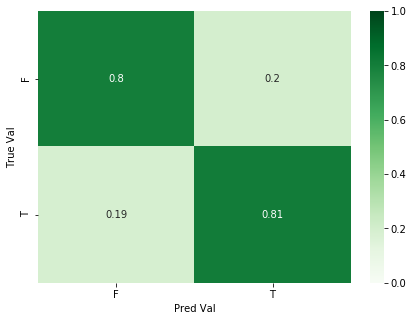

In [135]:
confusion_reporting(y_test, predictions_xgb_bin)

# Exploration of Errors

In [104]:
pred_df = y_test.to_frame()
pred_df['pred_bin'] = predictions_xgb_bin
pred_df['pred_bin'] = pred_df['pred_bin'].apply(lambda x: int(x))
pred_df.drop('cast_code', axis=1, inplace=True)

pred_df

exam_df = test_df.join(pred_df)

display(exam_df.head())
display(exam_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall,bill_slug,pred_bin
272,113,Senate,11,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,0,1,0,0,1,1,11,HR325-113,1
273,113,Senate,11,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,0,0,1,0,0,1,11,HR325-113,0
274,113,Senate,11,14226,0,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,0,1,0,0,1,1,11,HR325-113,1
275,113,Senate,11,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,0,0,1,0,0,1,11,HR325-113,0
276,113,Senate,11,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,0,0,1,0,0,1,11,HR325-113,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7052 entries, 272 to 22951
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       7052 non-null   int64  
 1   chamber                        7052 non-null   object 
 2   rollnumber                     7052 non-null   int64  
 3   icpsr                          7052 non-null   int64  
 4   cast_code                      7052 non-null   int64  
 5   state_abbrev                   7052 non-null   object 
 6   bioname                        7052 non-null   object 
 7   bioguide_id                    7052 non-null   object 
 8   born                           7052 non-null   int64  
 9   nominate_dim1                  7052 non-null   float64
 10  nominate_dim2                  7052 non-null   float64
 11  party                          7052 non-null   object 
 12  last_name                      7052 non-null 

None

In [106]:
exam_df[exam_df['cast_code'] != exam_df['pred_bin']].groupby('bioname').count()

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioguide_id,born,nominate_dim1,nominate_dim2,...,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall,bill_slug,pred_bin
bioname,,,,,,,,,,,,,,,,,,,,,
"ALEXANDER, Lamar",10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
"AYOTTE, Kelly",5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
"BALDWIN, Tammy",9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
"BARRASSO, John A.",20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
"BAUCUS, Max Sieben",3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WARREN, Elizabeth",9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
"WHITEHOUSE, Sheldon",10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
"WICKER, Roger F.",8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8


# Decile Graph

In [110]:
test_v_pred_df = pd.DataFrame(list(zip(y_test, predictions_xgb)), columns=['test', 'pred'])
test_v_pred_df['pred_bin'] = test_v_pred_df['pred'].apply(lambda x: round(x))

deciles = test_v_pred_df.groupby(pd.qcut(test_v_pred_df['pred'], 20)).sum()
deciles

,test,pred,pred_bin
pred,,,
"(0.007319999999999999, 0.0747]",27,15.917292,0
"(0.0747, 0.132]",81,36.350025,0
"(0.132, 0.202]",77,57.915650,0
"(0.202, 0.297]",57,87.409137,0
"(0.297, 0.406]",136,122.632613,0
"(0.406, 0.52]",142,163.054891,67
"(0.52, 0.631]",236,202.765290,352
"(0.631, 0.712]",284,237.134278,353
"(0.712, 0.772]",296,261.953326,352


In [124]:
x = [round((x.left + x.right)/2, 2) for x in deciles.index]
labels = [0] + [x.right for x in deciles.index]
x = np.array(x)
x

array([0.04, 0.1 , 0.17, 0.25, 0.35, 0.46, 0.58, 0.67, 0.74, 0.79, 0.83,
       0.87, 0.9 , 0.92, 0.93, 0.94, 0.95, 0.97, 0.98, 0.99])

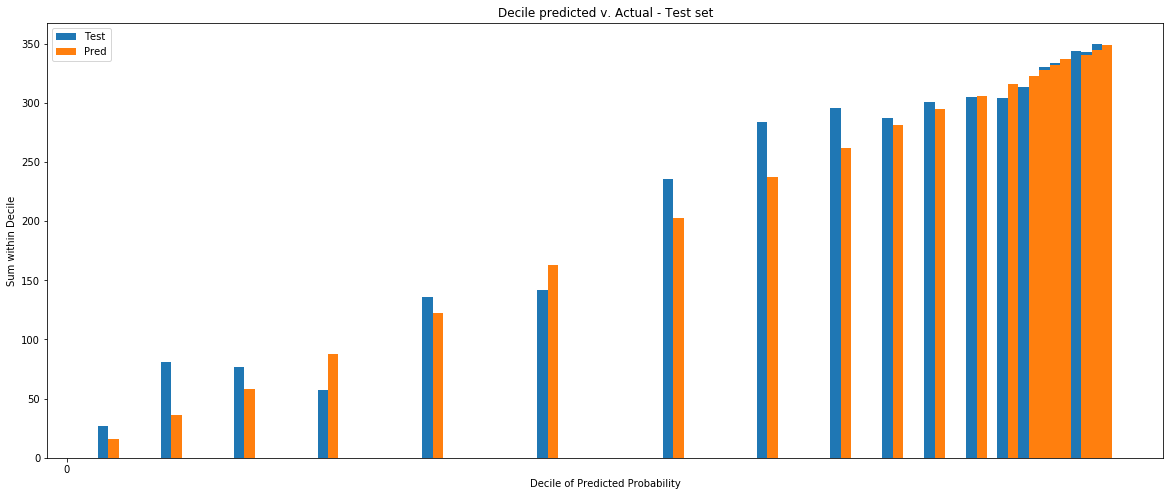

In [125]:
# plt.figure(figsize=(10,8))
# plt.bar(x, deciles['test'], width=.08)
# plt.bar(x, deciles['pred_bin'], width=.08)

fig, ax = plt.subplots(figsize=(20,8))

width = 0.01         # the width of the bars

test_bar = x-(width/2)
pred_bar = x+(width/2)

p1 = ax.bar(test_bar, deciles['test'], width, label='Test')
p2 = ax.bar(pred_bar, deciles['pred'], width, label='Pred')

ax.set_title('Decile predicted v. Actual - Test set')
ax.set_xticks(range(0,1,20))
ax.set_xlabel('Decile of Predicted Probability')
ax.set_ylabel('Sum within Decile')

plt.legend()
plt.show()

# Summary Exploration

In [84]:
display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall,bill_slug
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,1,0,1,0,1,1,0,1,SRES15-113
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,1,0,1,1,1,0,0,1,SRES15-113
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,1,0,1,0,1,1,0,1,SRES15-113
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,1,0,1,1,1,0,0,1,SRES15-113
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,1,0,1,1,1,0,0,1,SRES15-113


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23226 entries, 0 to 23225
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       23226 non-null  int64  
 1   chamber                        23226 non-null  object 
 2   rollnumber                     23226 non-null  int64  
 3   icpsr                          23226 non-null  int64  
 4   cast_code                      23226 non-null  int64  
 5   state_abbrev                   23226 non-null  object 
 6   bioname                        23226 non-null  object 
 7   bioguide_id                    23226 non-null  object 
 8   born                           23226 non-null  int64  
 9   nominate_dim1                  23226 non-null  float64
 10  nominate_dim2                  23226 non-null  float64
 11  party                          23226 non-null  object 
 12  last_name                      23226 non-null 

None

In [90]:
main_df.summary.sample().values

array(['Water Resources Development Act of 2016 TITLE I--PROGRAM REFORMS (Sec. 1001) This bill amends the Water Resources Development Act of 1986 (WRDA 1986) to allow the U.S. Army Corps of Engineers to provide technical assistance to nonfederal interests for feasibility studies of proposed water resources development projects if the nonfederal interest contracts to pay the costs of such assistance.  (Sec. 1002) The Corps of Engineers may receive and repay funds from states or political subdivisions for immediate use on authorized water resources development studies or projects (currently, only flood-control projects). The definition of "state" for such purposes is expanded to include the District of Columbia, Puerto Rico, other U.S. territories or possessions, federally recognized Indian tribes, and other native entities.  (Sec. 1003) The Water Resources Reform and Development Act of 2014 (WRRDA 2014) is amended to allow the Corps of Engineers to accept materials, services, or funds f

# Run whole DF through Model

In [148]:
dep_col = 'cast_code'

logit_features = list(pd.read_pickle('final_features.pkl')['feature'].values)

text_cols = ['summary']

indep_cols = logit_features + text_cols

In [149]:
main_df['bill_slug'] = main_df['bill_number'] + '-' + main_df['congress'].apply(lambda x: str(x))

In [150]:
non_text_cols = [x for x in indep_cols if x not in text_cols]

y = main_df[dep_col]
X = main_df[indep_cols]

X_sc = scalar.transform(X[non_text_cols])

X_df = pd.DataFrame(X_sc, index=y.index, columns=X[non_text_cols].columns).join(X[text_cols])

In [151]:
unique_sum_df = pd.Series(X_df['summary'].unique())

In [152]:
# Load cached model
module_path = 'universal-sentence-encoder_4'
embed = hub.load(module_path)

In [153]:
# Create embeddings 
X_embeddings = embed(unique_sum_df.values)

In [154]:
#turn the embeddings into dataframes to rejoin with the unique summaries
sum_cols = ['sum_'+str(i) for i in range(np.shape(X_embeddings)[1])]

vec_sum_df = unique_sum_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_embeddings), 
                                                                      columns=sum_cols))

In [155]:
#merge the vectorized train and test dfs back onto the main train/test dfs, keeping original indexs
X_df['copy_index'] = X_df.index

X_vec = X_df.merge(vec_sum_df, on='summary', how='left').set_index('copy_index')
X_vec

,sponsor_is_same_party,nominate_dim1,cosponsor_my_party,age,tenure,nominate_dim2,cosponsor_my_party^2,percent_campaign_vote,cosponsors^2,cosponsors,...,sum_502,sum_503,sum_504,sum_505,sum_506,sum_507,sum_508,sum_509,sum_510,sum_511
copy_index,,,,,,,,,,,,,,,,,,,,,
0,-0.990156,0.483464,-0.419252,1.297797,2.734648,0.406081,-0.229326,0.416801,-0.233759,-0.52961,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
1,1.009942,-0.655012,-0.419252,0.909358,2.734648,0.283017,-0.229326,1.765431,-0.233759,-0.52961,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
2,-0.990156,0.618074,-0.419252,1.686236,2.511699,-0.013783,-0.229326,0.758658,-0.233759,-0.52961,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
3,1.009942,-0.972143,-0.419252,1.103577,2.065801,-1.754769,-0.229326,0.560122,-0.233759,-0.52961,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
4,1.009942,-0.994958,-0.419252,1.006467,2.511699,-0.245432,-0.229326,0.756308,-0.233759,-0.52961,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23221,1.009942,-0.782777,6.603996,2.366004,1.954327,-0.502417,9.250187,-0.438427,11.271169,7.50787,...,-0.046261,-0.046261,0.040413,-0.046261,-0.046261,0.045969,0.046261,0.044932,-0.046215,0.046219
23222,1.009942,-0.969861,6.603996,0.715138,1.954327,-0.806456,9.250187,0.131333,11.271169,7.50787,...,-0.046261,-0.046261,0.040413,-0.046261,-0.046261,0.045969,0.046261,0.044932,-0.046215,0.046219
23223,-0.990156,0.084199,5.445160,0.520919,1.508428,-1.743910,6.392959,1.072320,11.271169,7.50787,...,-0.046261,-0.046261,0.040413,-0.046261,-0.046261,0.045969,0.046261,0.044932,-0.046215,0.046219


In [156]:
#define cols
model_cols = non_text_cols + sum_cols

In [165]:
# Get predictions for entire dataset
predictions_xgb = clf_xgb.predict_proba(X_vec[model_cols])
predictions_xgb = [item[1] for item in predictions_xgb]
predictions_xgb_bin = [1 if item > .6 else 0 for item in predictions_xgb]

[[ 6108   689]
 [ 1675 14754]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      6797
           1       0.96      0.90      0.93     16429

    accuracy                           0.90     23226
   macro avg       0.87      0.90      0.88     23226
weighted avg       0.91      0.90      0.90     23226

Accuracy score: 0.8982
F1 score: 0.9258


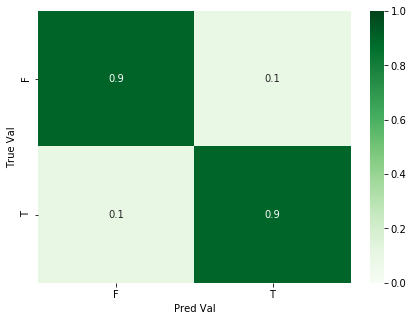

In [166]:
confusion_reporting(y, predictions_xgb_bin)

In [169]:
pred_df = pd.DataFrame(list(zip(predictions_xgb, predictions_xgb_bin)), columns=['predict_proba', 'pred_60'])
pred_df = main_df.join(pred_df)
pred_df

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall,bill_slug,predict_proba,pred_60
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,0,1,0,1,1,0,1,SRES15-113,0.752075,1
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,0,1,1,1,0,0,1,SRES15-113,0.992039,1
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,0,1,0,1,1,0,1,SRES15-113,0.667370,1
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,0,1,1,1,0,0,1,SRES15-113,0.983139,1
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,0,1,1,1,0,0,1,SRES15-113,0.984826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23221,116,Senate,508,49300,1,CA,"FEINSTEIN, Dianne",F000062,1933,-0.268,...,0,40401,1,1,0,0,508,HR748-116,0.988354,1
23222,116,Senate,508,49308,1,WA,"MURRAY, Patty",M001111,1950,-0.350,...,0,40401,1,1,0,0,508,HR748-116,0.982269,1
23223,116,Senate,508,49703,1,ME,"COLLINS, Susan Margaret",C001035,1952,0.112,...,0,28224,0,1,1,0,508,HR748-116,0.975451,1
23224,116,Senate,508,49706,1,WY,"ENZI, Michael B.",E000285,1944,0.544,...,0,28224,0,1,1,0,508,HR748-116,0.969952,1


# Saving Model Attributes

In [170]:
features = indep_cols
features_fn = 'final_xgb_features.sav'
joblib.dump(features, features_fn)

['final_xgb_features.sav']

In [171]:
scaler = scalar
scaler_fn = 'final_xgb_scaler.sav'
joblib.dump(scaler, scaler_fn)

['final_xgb_scaler.sav']

In [172]:
model = clf_xgb
model_fn = 'final_xgb_model.sav'
joblib.dump(model, model_fn)

['final_xgb_model.sav']

In [173]:
final_df = pred_df
df_fn = 'pred_xgb_df.sav'
joblib.dump(final_df, df_fn)

['pred_xgb_df.sav']